## Data Science Project: Star, Galaxy, and Quasar Classification




In [ ]:


!pip install pandas numpy scikit-learn catboost tensorflow tqdm seaborn matplotlib pykan


In [1]:
# Code Cell: Imports and settings

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, silhouette_score

from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

import torch



import time
from tqdm.notebook import tqdm

# Basic plot settings
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (8, 5)


# 1. Data Loading, Basic Preprocessing, and Exploratory Data Analysis

## 1.1. Data Loading and Preprocessing


In [2]:
# Code Cell:
directory = r'C:\Users\kiril\OneDrive\Desktop\Machine-Learning-Final-main\star_classification.csv'
data = pd.read_csv(directory)

# Drop unnecessary columns
data.drop(columns=['obj_ID', 'run_ID', 'rerun_ID', 'field_ID', 
                   'spec_obj_ID', 'plate', 'MJD', 'fiber_ID'], 
          inplace=True)

print("Data loaded. Shape:", data.shape)
data.head()


Data loaded. Shape: (100000, 10)


,alpha,delta,u,g,r,i,z,cam_col,class,redshift
0,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,2,GALAXY,0.634794
1,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,5,GALAXY,0.779136
2,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,2,GALAXY,0.644195
3,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,3,GALAXY,0.932346
4,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,3,GALAXY,0.116123


## 1.2. Exploratory Data Analysis (EDA)


alpha = Right Ascension angle (at J2000 epoch)

delta = Declination angle (at J2000 epoch)

u = Ultraviolet filter in the photometric system

g = Green filter in the photometric system

r = Red filter in the photometric system

i = Near Infrared filter in the photometric system

z = Infrared filter in the photometric system

cam_col = Camera column to identify the scanline within the run

class = object class (galaxy, star or quasar object)

redshift = redshift value based on the increase in wavelength


In [5]:

data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 10 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   alpha     100000 non-null  float64
 1   delta     100000 non-null  float64
 2   u         100000 non-null  float64
 3   g         100000 non-null  float64
 4   r         100000 non-null  float64
 5   i         100000 non-null  float64
 6   z         100000 non-null  float64
 7   cam_col   100000 non-null  int64  
 8   class     100000 non-null  object 
 9   redshift  100000 non-null  float64
dtypes: float64(8), int64(1), object(1)
memory usage: 7.6+ MB


In [6]:
data.isnull().sum()

alpha       0
delta       0
u           0
g           0
r           0
i           0
z           0
cam_col     0
class       0
redshift    0
dtype: int64

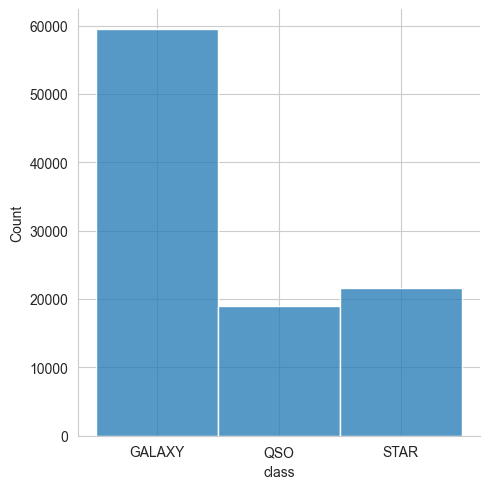

In [8]:
sns.displot(data["class"])
plt.show()

# 2. Encode the 'class' column to numeric labels


In [9]:
# Code Cell:
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(data['class'])
data['class'] = encoded_labels
target = data['class']

print("Classes after LabelEncoder:", label_encoder.classes_)


Classes after LabelEncoder: ['GALAXY' 'QSO' 'STAR']


# 3. Split into training and test sets, then apply StandardScaler


In [10]:
# Code Cell:
features = data.columns.drop('class')

X_train, X_test, y_train, y_test = train_test_split(
    data.drop('class', axis=1),
    target,
    test_size=0.2,
    random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=features)
X_test_scaled  = pd.DataFrame(X_test_scaled, columns=features)

print("Train set size:", X_train.shape, "Test set size:", X_test.shape)


Train set size: (80000, 9) Test set size: (20000, 9)


# 4. RandomizedSearchCV for RandomForest, followed by training on the best parameters


In [11]:
# Code Cell:
from sklearn.model_selection import cross_val_score

param_grid = {
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

def evaluate_model(model, X, y, cv=5):
    scores = cross_val_score(model, X, y, cv=cv, scoring='accuracy', n_jobs=-1)
    return np.mean(scores)

n_iter = 20
best_score = 0.0
best_params = None

start_time = time.time()
print("Starting RandomizedSearch for Random Forest...\n")

with tqdm(total=n_iter, desc="Optimizing Random Forest") as pbar:
    for i in range(n_iter):
        # Randomly choose params
        params = {k: np.random.choice(v) for k, v in param_grid.items()}
        model = RandomForestClassifier(**params, random_state=42)
        score = evaluate_model(model, X_train_scaled, y_train)

        if score > best_score:
            best_score = score
            best_params = params

        pbar.update(1)
        pbar.set_postfix({'Best Score': f"{best_score:.4f}"})

print(f"\nRandom Search completed in {time.time() - start_time:.2f} seconds")
print(f"Best parameters: {best_params}")
print(f"Best CV score: {best_score:.4f}")

rf_optimized = RandomForestClassifier(**best_params, random_state=42)
rf_optimized.fit(X_train_scaled, y_train)

y_pred_rf = rf_optimized.predict(X_test_scaled)
print("Accuracy (Random Forest):", accuracy_score(y_test, y_pred_rf))


Starting RandomizedSearch for Random Forest...



Optimizing Random Forest:   0%|          | 0/20 [00:00<?, ?it/s]


Random Search completed in 295.02 seconds
Best parameters: {'n_estimators': 100, 'max_depth': None, 'min_samples_split': 5, 'min_samples_leaf': 1}
Best CV score: 0.9785
Accuracy (Random Forest): 0.97805


# 5. Training CatBoost, SVM, and MLP, then evaluating their accuracy


In [10]:
# Code Cell:
catboost_model = CatBoostClassifier(iterations=1000, learning_rate=0.1, depth=6, verbose=0)
catboost_model.fit(X_train_scaled, y_train)
y_pred_catboost = catboost_model.predict(X_test_scaled)
print("CatBoost Accuracy:", accuracy_score(y_test, y_pred_catboost))

svm_model = SVC(kernel='linear')
svm_model.fit(X_train_scaled, y_train)
y_pred_svm = svm_model.predict(X_test_scaled)
print("SVM Accuracy:", accuracy_score(y_test, y_pred_svm))

mlp_model = MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, random_state=42)
mlp_model.fit(X_train_scaled, y_train)
y_pred_mlp = mlp_model.predict(X_test_scaled)
print("MLP Accuracy:", accuracy_score(y_test, y_pred_mlp))


CatBoost Accuracy: 0.97775
SVM Accuracy: 0.9593
MLP Accuracy: 0.9726


# 6. Classification reports and confusion matrices


c:\Users\kiril\OneDrive\Desktop\Machine-Learning-Final-main\env\lib\site-packages\sklearn\preprocessing\_label.py:151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Random Forest Classification Report:
               precision    recall  f1-score   support

      GALAXY       0.98      0.99      0.98     11860
         QSO       0.96      0.92      0.94      3797
        STAR       1.00      1.00      1.00      4343

    accuracy                           0.98     20000
   macro avg       0.98      0.97      0.97     20000
weighted avg       0.98      0.98      0.98     20000

CatBoost Classification Report:
               precision    recall  f1-score   support

      GALAXY       0.98      0.99      0.98     11860
         QSO       0.96      0.93      0.94      3797
        STAR       0.99      1.00      1.00      4343

    accuracy                           0.98     20000
   macro avg       0.98      0.97      0.97     20000
weighted avg       0.98      0.98      0.98     20000

SVM Classification Report:
               precision    recall  f1-score   support

      GALAXY       0.96      0.97      0.97     11860
         QSO       0.95      0

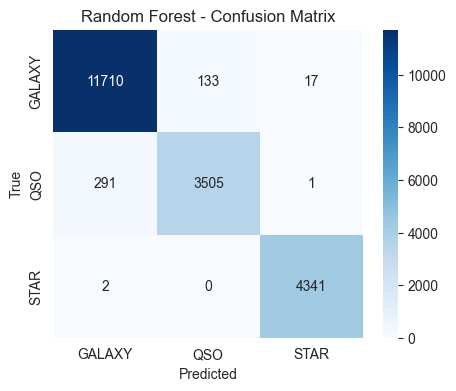

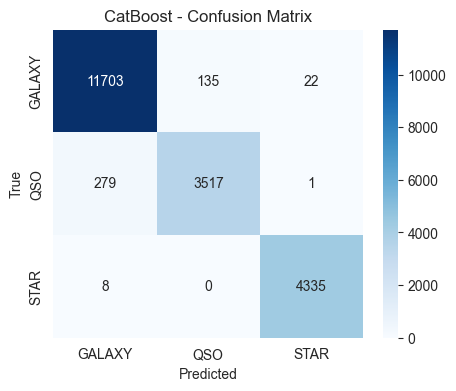

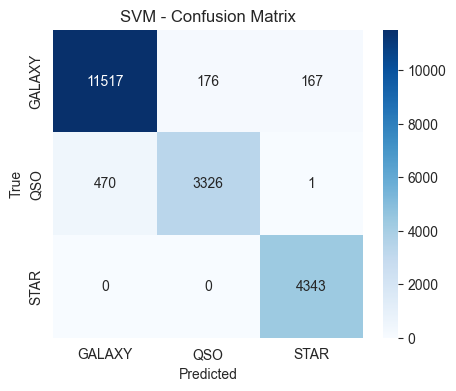

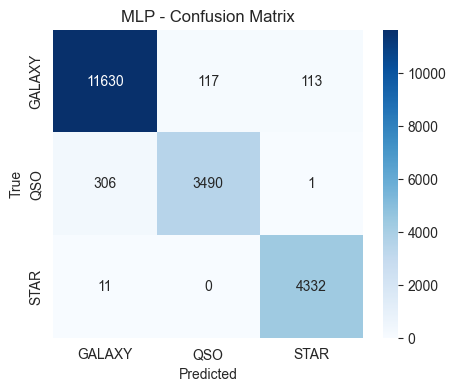

In [11]:
# Code Cell:
y_test_text              = label_encoder.inverse_transform(y_test)
y_pred_rf_text           = label_encoder.inverse_transform(y_pred_rf)
y_pred_catboost_text     = label_encoder.inverse_transform(y_pred_catboost)
y_pred_svm_text          = label_encoder.inverse_transform(y_pred_svm)
y_pred_mlp_text          = label_encoder.inverse_transform(y_pred_mlp)

print("Random Forest Classification Report:\n",
      classification_report(y_test_text, y_pred_rf_text))
print("CatBoost Classification Report:\n",
      classification_report(y_test_text, y_pred_catboost_text))
print("SVM Classification Report:\n",
      classification_report(y_test_text, y_pred_svm_text))
print("MLP Classification Report:\n",
      classification_report(y_test_text, y_pred_mlp_text))

# Confusion matrices
models_dict = {
    "Random Forest": y_pred_rf_text,
    "CatBoost": y_pred_catboost_text,
    "SVM": y_pred_svm_text,
    "MLP": y_pred_mlp_text
}

for model_name, preds in models_dict.items():
    cm = confusion_matrix(y_test_text, preds, labels=label_encoder.classes_)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d',
                xticklabels=label_encoder.classes_,
                yticklabels=label_encoder.classes_, cmap="Blues")
    plt.title(f"{model_name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()


# 7. Correlation Matrix Heatmap


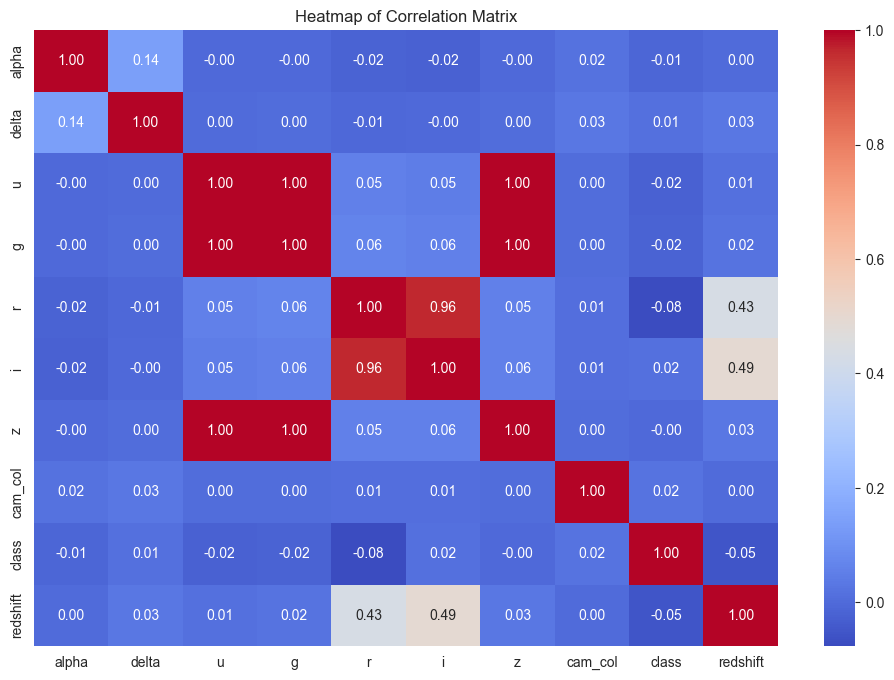

In [12]:
# Code Cell:
correlation_matrix = data.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Heatmap of Correlation Matrix")
plt.show()


# 8. Feature Importances (RandomForestClassifier)


Feature Importances (Random Forest):
 redshift    0.645250
z           0.102337
g           0.067474
i           0.061818
u           0.060134
r           0.037405
delta       0.011497
alpha       0.011179
cam_col     0.002906
dtype: float64


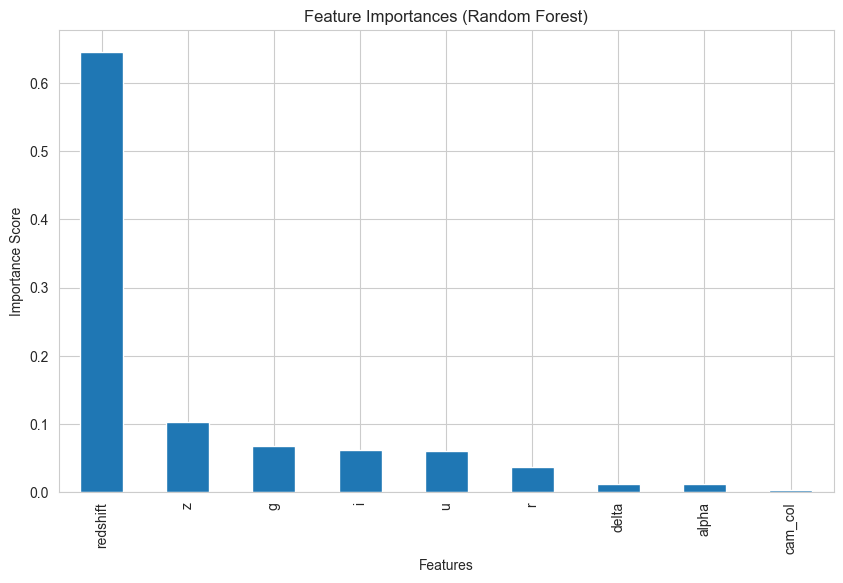

In [13]:
# Code Cell:
feature_importances = pd.Series(rf_optimized.feature_importances_, index=X_train.columns)
sorted_feature_importances = feature_importances.sort_values(ascending=False)

print("Feature Importances (Random Forest):\n", sorted_feature_importances)

plt.figure(figsize=(10, 6))
sorted_feature_importances.plot(kind='bar')
plt.title("Feature Importances (Random Forest)")
plt.xlabel("Features")
plt.ylabel("Importance Score")
plt.show()


# 9. K-Means Clustering (Elbow Method + Silhouette Analysis)


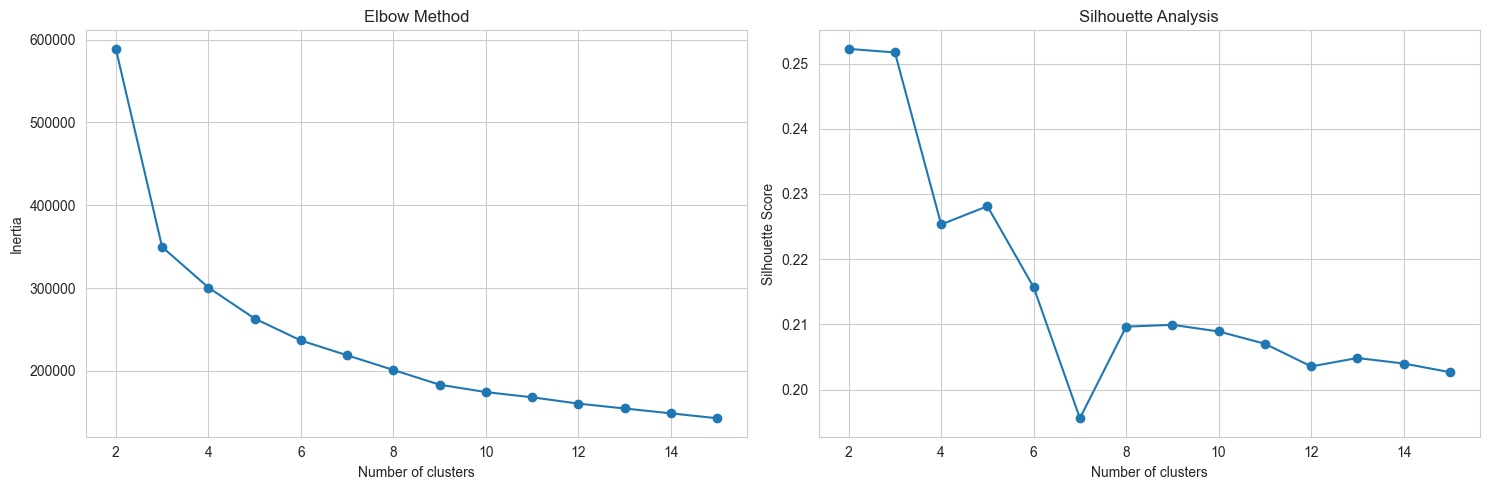

Optimal number of clusters: 2

Cluster composition:
 class      0      1      2
row_0                     
0      28532  14473   6998
1      19053    691  10253


In [13]:
# Code Cell:
from sklearn.cluster import KMeans
def analyze_clusters(X, y, max_clusters=15):
    scaler_local = StandardScaler()
    X_scaled = scaler_local.fit_transform(X)

    inertias = []
    silhouette_scores = []
    
    for k in range(2, max_clusters + 1):
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(X_scaled)
        inertias.append(kmeans.inertia_)
        silhouette_scores.append(silhouette_score(X_scaled, kmeans.labels_))

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    ax1.plot(range(2, max_clusters + 1), inertias, marker='o')
    ax1.set_xlabel("Number of clusters")
    ax1.set_ylabel("Inertia")
    ax1.set_title("Elbow Method")

    ax2.plot(range(2, max_clusters + 1), silhouette_scores, marker='o')
    ax2.set_xlabel("Number of clusters")
    ax2.set_ylabel("Silhouette Score")
    ax2.set_title("Silhouette Analysis")

    plt.tight_layout()
    plt.show()

    optimal_clusters = silhouette_scores.index(max(silhouette_scores)) + 2
    print(f"Optimal number of clusters: {optimal_clusters}")

    kmeans_optimal = KMeans(n_clusters=optimal_clusters, random_state=42)
    cluster_labels = kmeans_optimal.fit_predict(X_scaled)

    cluster_composition = pd.crosstab(cluster_labels, y)
    print("\nCluster composition:\n", cluster_composition)

    return cluster_labels, optimal_clusters

cluster_labels, optimal_clusters = analyze_clusters(X_train_scaled, y_train)



# 9.1. Checking Detected Clusters vs. Original Classes
 
This step compares the number of clusters found by K-Means with the actual 
number of classes in the training data. If there are more clusters than classes, 
we analyze which points form these “new” clusters.


In [20]:
# Code Cell:
# Compare the number of clusters with the original number of classes
original_classes = len(np.unique(y_train))
print(f"\nNumber of original classes: {original_classes}")
print(f"Number of detected clusters: {optimal_clusters}")

if optimal_clusters > original_classes:
    print("Potential new clusters detected!")
    for cluster_id in range(original_classes, optimal_clusters):
        cluster_mask = (cluster_labels == cluster_id)
        cluster_size = np.sum(cluster_mask)
        print(f"\nAnalyzing potential new cluster {cluster_id}:")
        print(f"  Cluster size: {cluster_size}")
        # Optional: examine average feature values in that cluster
        cluster_data = X_train_scaled[cluster_mask]
        print("  Average feature values in this cluster:")
        print(cluster_data.mean())
elif optimal_clusters < original_classes:
    print("Some classes might be merged into fewer clusters.")
else:
    print("Number of clusters matches the number of original classes.")



Number of original classes: 3
Number of detected clusters: 2
Some classes might be merged into fewer clusters.


# 10. Interpreting the Redshift Distributions by Class

Below is an astrophysical interpretation of why redshift helps distinguish Stars, Galaxies, and Quasars. Remember that in our dataset, numeric labels (e.g., 0, 1, 2) map to actual classes (e.g., STAR, GALAXY, QSO). If needed, refer to the printout of `label_encoder.classes_` to see which label corresponds to each object type.

- **Stars (Class 0)**:  
  They reside in our own Galaxy (the Milky Way), so their cosmological redshift is effectively zero. On the histogram or KDE plot, this results in a tight cluster near 0.

- **Galaxies (Class 1)**:  
  These can be at various cosmological distances, so their redshift values can range from small (similar to stars) up to moderate values (often up to 2–3). The histogram usually shows a broader spread, reflecting a mix of nearer and farther galaxies.

- **Quasars (Class 2)**:  
  Quasars are typically the most distant objects in such surveys, often at higher redshift. For example, many may exceed values above 3 or 4, appearing as a long tail to the right or even lying beyond our chosen 99th-percentile cutoff. This behavior aligns with the fact that quasars are extremely distant Active Galactic Nuclei (AGN), yielding the highest observed redshifts.

In our code, we limited the x-axis to the 99th percentile of `redshift` (using `quantile(0.99)`) to avoid stretching the plot due to a small number of extremely large values. If many quasars have redshift values above that 99th-percentile threshold, they will not appear on the zoomed-in histogram but can be visualized if we remove or increase the cutoff. 

Overall, these distributions typically match the usual expectations:
- Stars (label ~ 0) at or near redshift = 0.
- Galaxies (label ~ 1) at moderate redshift ranges.
- Quasars (label ~ 2) at the highest redshifts.






Mapping of numeric labels to original class names:
Numeric label 0 -> class 'GALAXY'
Numeric label 1 -> class 'QSO'
Numeric label 2 -> class 'STAR'

Column 'redshift' is present in the dataset.
Redshift statistics:
 count    100000.000000
mean          0.576661
std           0.730707
min          -0.009971
25%           0.054517
50%           0.424173
75%           0.704154
max           7.011245
Name: redshift, dtype: float64
99th percentile of redshift = 3.1270803999999996


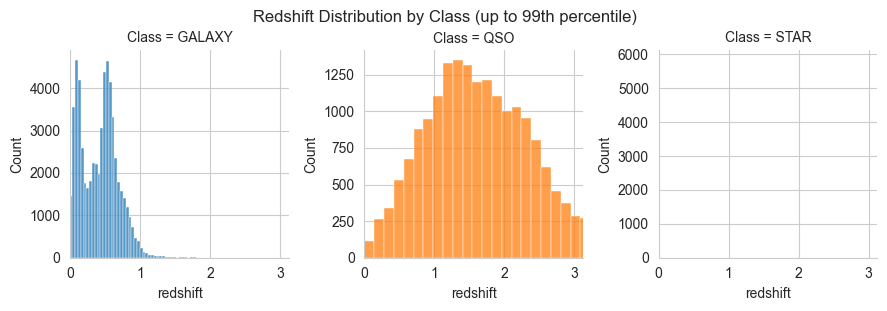


Accuracy using only 'redshift': 0.9168


In [19]:

print("Mapping of numeric labels to original class names:")
for numeric_label, class_name in enumerate(label_encoder.classes_):
    print(f"Numeric label {numeric_label} -> class '{class_name}'")



if 'redshift' in data.columns:
    print("\nColumn 'redshift' is present in the dataset.")
    
    # Show descriptive statistics for redshift
    stats = data['redshift'].describe()
    print("Redshift statistics:\n", stats)
    
    # Compute the 99th percentile of 'redshift' so we can zoom in on the main data range
    upper_limit = data['redshift'].quantile(0.99)
    print("99th percentile of redshift =", upper_limit)
    
    # Create a new column 'class_name' with the original (string) class labels
    # so that FacetGrid can display them nicely. This is optional: you could keep numeric.
    data['class_name'] = label_encoder.inverse_transform(data['class'])

    # Build a FacetGrid: one subplot per class
    g = sns.FacetGrid(data, col="class_name", hue="class_name", sharex=False, sharey=False)
    g.map(sns.histplot, "redshift", bins=50)

    # Limit the x-axis to the 99th percentile to avoid extreme outliers compressing the chart
    for ax in g.axes.flat:
        ax.set_xlim(0, upper_limit)

    g.set_titles("Class = {col_name}")
    g.fig.suptitle("Redshift Distribution by Class (up to 99th percentile)", y=1.02)
    plt.show()

   
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.metrics import accuracy_score

    X_single = data[['redshift']]
    y_single = data['class']  # numeric labels

    X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(
        X_single, y_single, 
        test_size=0.2, 
        random_state=42
    )

    clf_redshift = RandomForestClassifier(random_state=42)
    clf_redshift.fit(X_train_s, y_train_s)
    y_pred_s = clf_redshift.predict(X_test_s)

    acc_s = accuracy_score(y_test_s, y_pred_s)
    print(f"\nAccuracy using only 'redshift': {acc_s:.4f}")

else:
    print("\nNo 'redshift' column found. Possibly 'z' is just a magnitude filter, not actual redshift.")
